# Where is the data dense?

- Documentation describes **all** fields and values
- Often, only a small fraction of the fields and values appear in the dataset.
- In order to compute meaningful statistics, eliminate the rare fields and values.

In [1]:
import os
import sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

#Initialize and load weather dataframe

from pyspark import SparkContext
sc = SparkContext(master="local[4]")
#sc.version

import os
import sys

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType
from pyspark.sql.functions import udf
%pylab inline

# Just like using Spark requires having a SparkContext, using SQL requires an SQLContext
sqlContext = SQLContext(sc)

Populating the interactive namespace from numpy and matplotlib


## Count the number of records for each measurment

In [2]:
data_dir="../../resource/asnlib/publicdata/Data"

In [3]:
%%time
Query="""
SELECT measurement,COUNT(measurement) AS Count
FROM parquet.`{}`
GROUP BY measurement 
""".format(data_dir + '/US_state_weather.parquet')
Counts_pdf = sqlContext.sql(Query).toPandas()

CPU times: user 124 ms, sys: 12 ms, total: 136 ms
Wall time: 5.59 s


In [4]:
Counts_pdf.shape

(133, 2)

- There are 133 types of measurements in the data.
- Next, we list the number of records for the most common 7 types.

In [5]:
Counts_pdf.sort_values('Count', ascending=False).iloc[:7].reset_index(drop=True)

,measurement,Count
0,PRCP,1171396
1,SNOW,1051466
2,SNWD,899553
3,TMAX,687240
4,TMIN,687227
5,TOBS,528688
6,WT03,295366


## Select the 30 most common measurements.

In [6]:
%%time
top30=list(Counts_pdf.sort_values('Count', ascending=False).iloc[:30]['measurement'])
top30_str = 'measurement=\'{}\'\n'.format(top30[0])
for m in top30[1:]:
    top30_str += "\tor measurement=\'{}\'\n".format(m)

Query="""
SELECT *
FROM parquet.`{}`
WHERE ({})
""".format(data_dir + '/US_state_weather.parquet', top30_str)
print(Query)
Weather_df = sqlContext.sql(Query)
print('number of records=', Weather_df.count())


SELECT *
FROM parquet.`../../resource/asnlib/publicdata/Data/US_state_weather.parquet`
WHERE (measurement='PRCP'
	or measurement='SNOW'
	or measurement='SNWD'
	or measurement='TMAX'
	or measurement='TMIN'
	or measurement='TOBS'
	or measurement='WT03'
	or measurement='MDPR'
	or measurement='WT01'
	or measurement='DAPR'
	or measurement='WT04'
	or measurement='WT05'
	or measurement='WT11'
	or measurement='WT06'
	or measurement='WESD'
	or measurement='WESF'
	or measurement='WT16'
	or measurement='TAVG'
	or measurement='WT08'
	or measurement='WT18'
	or measurement='WT14'
	or measurement='PGTM'
	or measurement='WT09'
	or measurement='WT02'
	or measurement='AWND'
	or measurement='EVAP'
	or measurement='WDMV'
	or measurement='WDF2'
	or measurement='WSF2'
	or measurement='WSF5'
)

number of records= 7410400
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.71 s


## Count the number of undefined days

- Each record has a vector of 365 days. Some of the netries are undefined.
- We want to know the distribution of the number of undefined entries, grouped by measurement type.

### Using User Defined Functions (UDF)

- define a python function that operats on the `Values` field.

```python
def Count_nan(V):
    A=unpackArray(V,data_type=np.float16)
    return int(sum(np.isnan(A)))
```

- define and register the function as a UDF

```python
Count_nan_udf = udf(Count_nan,IntegerType())
```

- apply the UDF and create a new column

```python
Weather_df=Weather_df.withColumn("nan_no", Count_nan_udf(Weather_df.Values))
```

In [7]:
def unpackArray(x,data_type=np.int16):
    return np.frombuffer(x,dtype=data_type)

def Count_nan(V):
    A=unpackArray(V,data_type=np.float16)
    return int(sum(np.isnan(A)))

Count_nan_udf = udf(Count_nan, IntegerType())
Weather_df=Weather_df.withColumn("nan_no", Count_nan_udf(Weather_df.Values))

In [8]:
nan_rdd = Weather_df.rdd

## Compute histograms

We want to know for each type of measurements, the distribution of the number of nan entries (0-365).

### Histograms Using map and reduce

- We map each count (1-365) to a vector of 365 zeros with a single 1 at location "count"
- We create a histogram by adding the vectors.(reduceByKey())

In [9]:
def map_to_hist(n):
    a=np.zeros(367)
    a[n]=1
    return a
by_measurement=nan_rdd.map(lambda row: (row.Measurement,map_to_hist(row.nan_no)))

In [10]:
%%time
Hists=by_measurement.reduceByKey(lambda x,y:x+y).collect()

CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 2min 18s


## Finally, we plot the histograms

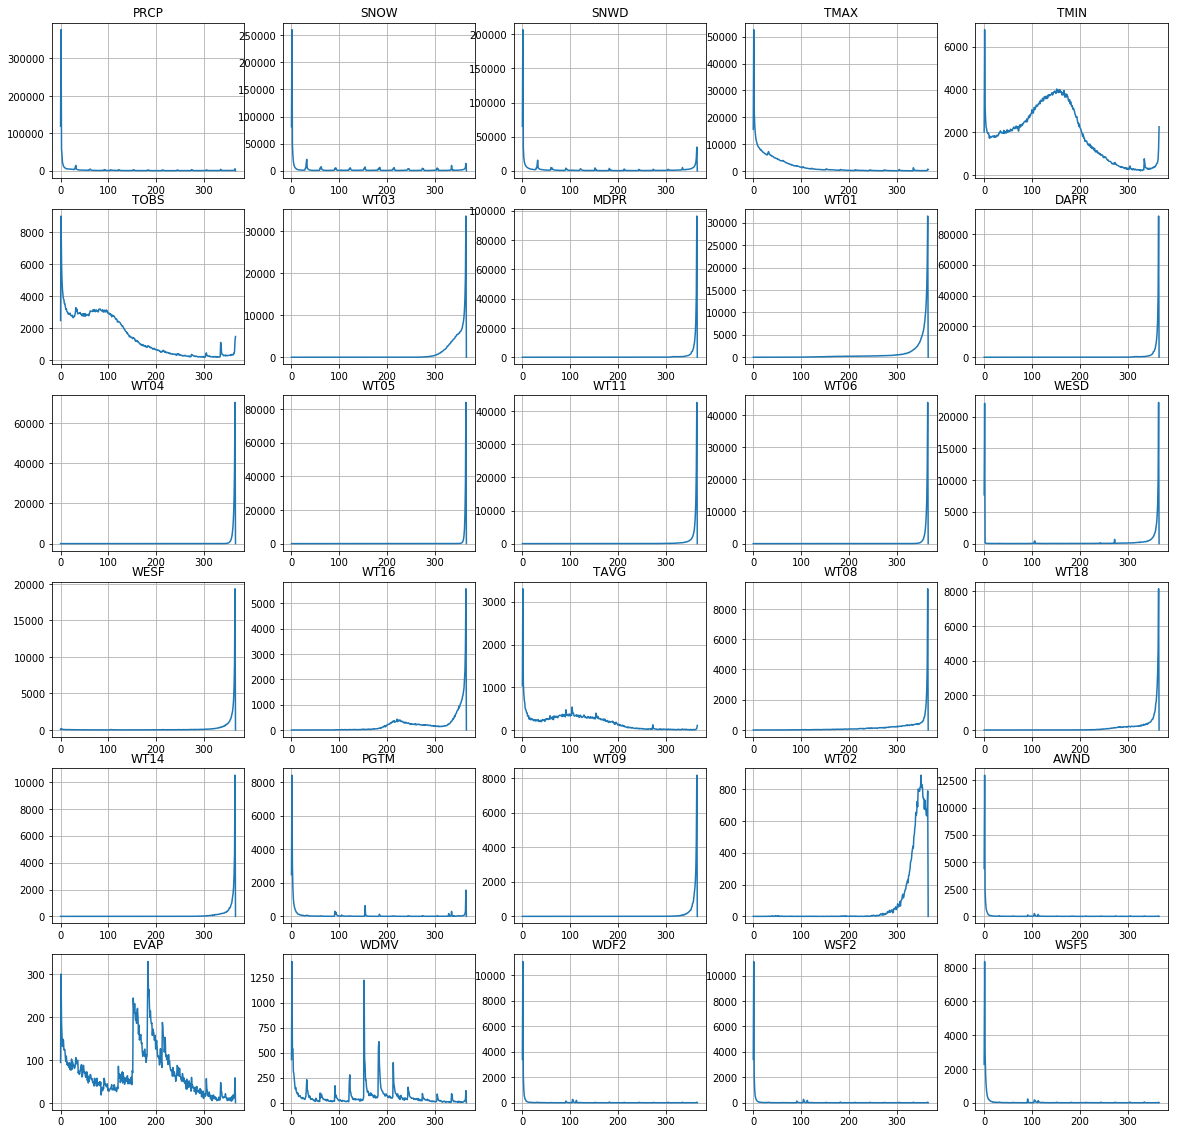

In [11]:
hists_dict = dict(Hists)

fig, axes = subplots(6, 5, figsize=(20, 20))
for i, name in enumerate(top30):
    row = i // 5
    col = i % 5
    ax = axes[row][col]
    
    ax.plot(hists_dict[name])
    ax.set_title(name)
    ax.set_xticks([0, 100, 200, 300])
    ax.grid()

## Summary

- Before analyzing a large dataset, it is important to know how dense it is.
- The most common measurement **PRCP** has 1.5 Million records.
- Measurements at location >=30 have fewer than 1,500 records.
- Of the 30 most common measurements, 20 have fewer than 60 defined value per year